In [2]:
#step 1 import required packages
import pandas as pd # load pandas package for importing csv files in correct format
# import as defines the identifier you want to use for the function e.g in this case 
# pd will call the pandas package
import matplotlib # load matplotlib package for plotting graphs
import os

In [3]:
#step 2 load open prescribing measures data to filter out a subset for testing all scripts
data = pd.read_csv('measures.csv', sep=',') #data is sepperated by , commas

In [4]:
#step 3 check data has imported correctly 
data.head(3) # Show top 3 entries to confirm successful data import

,measure,org_type,org_id,org_name,date,numerator,denominator,calc_value,percentile
0,ktt9_antibiotics,practice,P84650,THE ALEXANDRA PRACTICE,2014-10-01,199.0,3106.653507,0.064056,9.181078
1,ktt9_antibiotics,practice,P84673,ANCOATS URBAN VILLAGE MEDICAL PRACTICE,2014-10-01,463.0,4252.799604,0.108869,75.864700
2,ktt9_antibiotics,practice,P84071,WILBRAHAM SURGERY,2014-10-01,219.0,2275.856965,0.096227,57.540692


In [5]:
#step 4 Convert to a dataframe
dataframe = pd.DataFrame(data)
#view data frame
dataframe.head(3)

,measure,org_type,org_id,org_name,date,numerator,denominator,calc_value,percentile
0,ktt9_antibiotics,practice,P84650,THE ALEXANDRA PRACTICE,2014-10-01,199.0,3106.653507,0.064056,9.181078
1,ktt9_antibiotics,practice,P84673,ANCOATS URBAN VILLAGE MEDICAL PRACTICE,2014-10-01,463.0,4252.799604,0.108869,75.864700
2,ktt9_antibiotics,practice,P84071,WILBRAHAM SURGERY,2014-10-01,219.0,2275.856965,0.096227,57.540692


In [6]:
#step 5 sort dataframe first by number of prescriptions
dataframe_Sort = dataframe.sort_values("numerator")
#See the following URL to sort by more than one column: 
#https://www.geeksforgeeks.org/python-pandas-dataframe-sort_values-set-2/
dataframe_Sort.head(6)

,measure,org_type,org_id,org_name,date,numerator,denominator,calc_value,percentile
2050,ktt9_antibiotics,practice,P84659,DR HUSSAIN'S PRACTICE,2016-07-01,0.0,0.0,NaN,NaN
1003,ktt9_antibiotics,practice,P84063,DR CHEN & DAVIS,2015-08-01,0.0,0.0,NaN,NaN
1011,ktt9_antibiotics,practice,P84057,KAYA PRACTICE,2015-08-01,0.0,0.0,NaN,NaN
3978,ktt9_antibiotics,practice,P84623,ALEESHAN MEDICAL CENTRE,2018-03-01,0.0,0.0,NaN,NaN
1014,ktt9_antibiotics,practice,P84677,DIDSBURY MEDICAL CENTRE- DR ASHWORTH,2015-08-01,0.0,0.0,NaN,NaN
3974,ktt9_antibiotics,practice,P84063,DR CHEN & DAVIS,2018-03-01,0.0,0.0,NaN,NaN


In [17]:
# step 6 Check if any database entries (rows) have 0.0 prescriptions as these will need to be removed
NoAnti =  dataframe_Sort['numerator']==0.0
NoAnti.head(3)
#count number of rows with 0 prescriptions
PCo = len(dataframe_Sort[dataframe_Sort['numerator'] == 0.0]) 

In [18]:
#step 7 print warning meassage to user... using if statement e.g. 
if PCo>0:
    print('This dataset contains', PCo, 'entries with 0 prescriptions. These entries will be removed from the dataset.')
else:
    print('no errors were detected')

This dataset contains 345 entries with 0 prescriptions. These entries will be removed from the dataset.


In [22]:
# step 8 Identify all database entries with >0.0 prescriptions and remove
AntiP =  dataframe_Sort['numerator']>0.0
AntiP.head(3)
AntiP.tail(3)

4438    True
4346    True
4608    True
Name: numerator, dtype: bool

In [23]:
# step 9 Filter out all rows with 0 prescriptions
df_SF = dataframe_Sort[AntiP]
df_SF.head(3)

,measure,org_type,org_id,org_name,date,numerator,denominator,calc_value,percentile
2770,ktt9_antibiotics,practice,P84676,OSWALD ROAD MEDICAL PRACTICE,2017-02-01,1.0,0.00000,NaN,NaN
415,ktt9_antibiotics,practice,P84605,FERNCLOUGH SURGERY,2015-02-01,1.0,1089.97012,0.000917,0.242378
2633,ktt9_antibiotics,practice,P84676,OSWALD ROAD MEDICAL PRACTICE,2017-01-01,1.0,0.00000,NaN,NaN


In [24]:
#Check all rows with 0 prescriptions have been removed
min(df_SF.numerator) # check minimum value is not 0.0

1.0

In [25]:
#Calculate IQR
#Q1
q1 = df_SF['numerator'].quantile(0.25)
#Q3
q3 = df_SF['numerator'].quantile(0.75) 
#IQR
iqr=q3-q1
print(iqr)

219.0


In [26]:
#Calclate lower limit for outliers
LowOut = q1 - 1.5 * iqr #lower bound

In [27]:
#Calculate upper limit for outliers
HighOut = q3 + 1.5 * iqr #upper bound
HighOut

724.5

In [28]:
# TEST:filtering Values between Q1-1.5IQR and Q3+1.5IQR
# See https://stackoverflow.com/questions/34782063/how-to-use-pandas-filter-with-iqr
#Are Outliers present?
LowOutliers = df_SF['numerator']<=LowOut
HighOutliers = df_SF['numerator']>=HighOut
HighOutliers.tail(6)
HighOutliers.head(6)

2770    False
415     False
2633    False
3300    False
651     False
2840    False
Name: numerator, dtype: bool

In [29]:
# Filter out all rows with high and low outliers 
Outliers = df_SF[(df_SF['numerator'] < LowOut) | (df_SF['numerator'] > HighOut)] #|= OR
Outliers.head(3)

,measure,org_type,org_id,org_name,date,numerator,denominator,calc_value,percentile
4913,ktt9_antibiotics,practice,P84024,BOWLAND MEDICAL PRACTICE,2019-01-01,725.0,4197.163098,0.172736,99.227025
2168,ktt9_antibiotics,practice,P84029,BENCHILL MEDICAL PRACTICE,2016-08-01,725.0,5145.058829,0.140912,98.956269
550,ktt9_antibiotics,practice,P84024,BOWLAND MEDICAL PRACTICE,2015-03-01,726.0,4109.562702,0.176661,98.239571


In [30]:
#count number of outliers and print message to inform the user
NoOutliers = len(Outliers['numerator'])
print('This dataset contains', NoOutliers, 'Outliers, represented by the circles in the boxplot below.')

This dataset contains 154 Outliers, represented by the circles in the boxplot below.


{'whiskers': [<matplotlib.lines.Line2D at 0x7f1a90ea65c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1a90ea6c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1a90ea61d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1a90ea6f28>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1a90e33630>],
 'means': []}

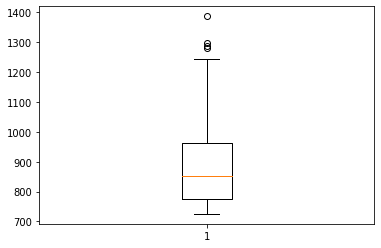

In [32]:
#plot boxplot for outliers...
import matplotlib
import matplotlib.pyplot as plt
plt.boxplot(Outliers.numerator)

In [302]:
# TODO: clean up code - remove test lines
#Improve annotations/comments
#Improve boxplot
#Combine code branches

In [33]:
# list unique name of practices with prescription outliers.
#Is there a trend?
GPlist=Outliers.org_name.unique()
print('This is a list of all the GP practices where antibioitc prescrition numbers have been identified as outliers:',
     GPlist)

This is a list of all the GP practices where antibioitc prescrition numbers have been identified as outliers: ['BOWLAND MEDICAL PRACTICE' 'BENCHILL MEDICAL PRACTICE'
 'THE AVENUE MEDICAL CENTRE' 'VALENTINE MEDICAL CENTRE'
 'NEW COLLEGIATE MEDICAL CENTRE' "ST GEORGE'S MEDICAL CENTRE"
 'GORTON MEDICAL CENTRE' 'DIDSBURY MEDICAL CENTRE - DR WHITAKER'
 'NORTHENDEN GROUP PRACTICE' 'BODEY MEDICAL CENTRE'
 'PEEL HALL MEDICAL CENTRE' 'THE ROBERT DARBISHIRE PRACTICE'
 'CITY HEALTH CENTRE']


In [34]:
Datelist=Outliers.date.unique()

In [35]:
Outliers[Outliers['org_name'].str.match('CITY HEALTH CENTRE')].head(3)
#Add line to Sam's graph of outlier range (same for all datasets)

,measure,org_type,org_id,org_name,date,numerator,denominator,calc_value,percentile
278,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2014-12-01,854.0,3302.252596,0.258611,98.944557
2702,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2017-02-01,857.0,4493.070547,0.190738,99.240506
1862,ktt9_antibiotics,practice,Y02849,CITY HEALTH CENTRE,2016-05-01,881.0,3880.348166,0.227041,99.370079


In [36]:
##Import matplotlib for making graphs,
##import pandas for reading in dataframe
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import numpy
import pandas as pd

In [37]:
##Read in our data and assign it to variable "data".
data = pd.read_csv("measures.csv", sep =',')

##To test we have imported data correctly,
##import first four rows, which includes column headers
print(data.loc[0:3,:])

            measure  org_type  org_id                                org_name  \
0  ktt9_antibiotics  practice  P84650                  THE ALEXANDRA PRACTICE   
1  ktt9_antibiotics  practice  P84673  ANCOATS URBAN VILLAGE MEDICAL PRACTICE   
2  ktt9_antibiotics  practice  P84071                       WILBRAHAM SURGERY   
3  ktt9_antibiotics  practice  P84049               THE AVENUE MEDICAL CENTRE   

         date  numerator  denominator  calc_value  percentile  
0  2014-10-01      199.0  3106.653507    0.064056    9.181078  
1  2014-10-01      463.0  4252.799604    0.108869   75.864700  
2  2014-10-01      219.0  2275.856965    0.096227   57.540692  
3  2014-10-01      850.0  5602.462544    0.151719   96.731943  


In [38]:
'''The first definition provides the user the ability to view the trends data for every surgery
within a particular geographical area.'''
def Plot_trends_all_surgeries(data):
    unique_org_ids = data['org_id'].unique() ##Get a list of the surgeries

    ax = plt.gca() ##Set the default axis for the graph

    for orgs_id in unique_org_ids: ##For each surgery in the list of unique surgery
        new_dataframe = data[data['org_id'] == str(orgs_id)] ##Get a new dataframe subset just for the one surgery 
        graph_points = new_dataframe[['date','numerator']] ##From the new dataframe, get the date and prescription number
    
        graph_points.plot(x='date',y='numerator', ax = ax) ##Plot date and prescriptions on same axis for all surgeries

    ax.get_legend().remove() ##Remove legend from graph, as very messy.
    plt.gcf().autofmt_xdate() ##Format the x-axis for date data
    plt.show() ##Show the plot
    
'''This function shows the summed prescribing information for every surgery within the geographical area for
a particular timepoint. This is displayed from 2014-2019'''
def Plot_trends_combined_surgeries(data):
    unique_date_ids = data['date'].unique() ##Get a list of all the reporting dates

    dates_axis = [] ##Initiate a list for dates
    summed_axis = [] ##Initiate a list to sum all data for that date

    for dates in unique_date_ids:
        dates_axis.append(dates) ##Append iterative dates to date_axis list
        new_dataframe = data[data['date'] == dates] ##Subset dataframe just for iterative date
        summed = new_dataframe['numerator'].sum() ##Sum the prescribing column
        summed_axis.append(summed) ##Append the sum to the list
    
    new_df = pd.DataFrame({'date_axis':dates_axis,'summed_axis':summed_axis}) ##Turn lists into dataframe to turn into a graph

    new_df.plot(x = 'date_axis', y = 'summed_axis') ##Plot new graph

    plt.gcf().autofmt_xdate() ##Format date axis
    plt.show() ##Show the plot.
    
'''This function allows the user to provide the data, and provide either the name or the ID
of a surgery, and see the trend over time just for that surgery. This can be used as an investigational
tool into surgeries of interest (e.g outliers)

Note: Using organisation names are case sensitive'''
def Plot_trends_pick_surgeries(data, name):
    if data['org_id'].str.endswith(name).any():
            
        ax = plt.gca() ##Set the default axis for the graph
    
        new_dataframe = data[data['org_id'] == str(name)] ##Get a new dataframe subset just for the one surgery 
        graph_points = new_dataframe[['date','numerator']] ##From the new dataframe, get the date and prescription number
    
        graph_points.plot(x='date',y='numerator', ax = ax) ##Plot date and prescriptions on same axis for all surgeries

        ax.legend(loc = 'upper right', labels=new_dataframe.iloc[0]['org_id'])
        plt.gcf().autofmt_xdate() ##Format the x-axis for date data
        plt.show() ##Show the plot
        
    elif data['org_name'].str.endswith(name).any():
        
        ax = plt.gca() ##Set the default axis for the graph
    
        new_dataframe = data[data['org_name'] == str(name)] ##Get a new dataframe subset just for the one surgery 
        graph_points = new_dataframe[['date','numerator']] ##From the new dataframe, get the date and prescription number
    
        graph_points.plot(x='date',y='numerator', ax = ax) ##Plot date and prescriptions on same axis for all surgeries

        ax.legend(loc = 'upper right', labels=new_dataframe.iloc[0]['org_id'])
        plt.gcf().autofmt_xdate() ##Format the x-axis for date data
        plt.show() ##Show the plot
        
        
    else:
        print('Could not find surgery!')
        

'''This function allows a user to pick any two surgeries and plot the prescribing information
on the same axis for both surgeries. This can be used to directly compare the prescribing
information for both surgeries.

So far, this function only works with organisation IDs and not organisation names.'''
def Plot_trends_two_surgeries_by_IDs(data, name1, name2):
    if data['org_id'].str.endswith(name1).any() & data['org_id'].str.endswith(name2).any():
    
        ax = plt.gca() ##Set the default axis for the graph

        for two_id in name1, name2: ##For each surgery in the list of unique surgery
            new_dataframe = data[data['org_id'] == str(two_id)] ##Get a new dataframe subset just for the one surgery 
            graph_points = new_dataframe[['date','numerator']] ##From the new dataframe, get the date and prescription number
    
            graph_points.plot(x='date',y='numerator', ax = ax) ##Plot date and prescriptions on same axis for all surgeries

        new_dataframe1 = data[data['org_id'] == str(name1)] ##Get a new dataframe subset just for the one surgery 
        legend_points1 = new_dataframe1[['org_id','org_name']] ##From the new dataframe, get the date and prescription number
        
        new_dataframe2 = data[data['org_id'] == str(name2)] ##Get a new dataframe subset just for the one surgery 
        legend_points2 = new_dataframe2[['org_id','org_name']] ##From the new dataframe, get the date and prescription number
                
        legendname1 = legend_points1.iloc[0]['org_id'] + ', ' + legend_points1.iloc[0]['org_name']
        legendname2 = legend_points2.iloc[0]['org_id'] + ', ' + legend_points2.iloc[0]['org_name']
        
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), labels=(legendname1, legendname2))
        plt.gcf().autofmt_xdate() ##Format the x-axis for date data
        plt.show() ##Show the plot
    
    else:
        print('One of the surgery IDs is incorrect!')

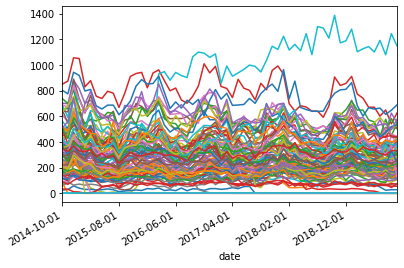

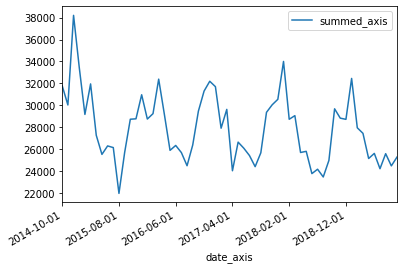

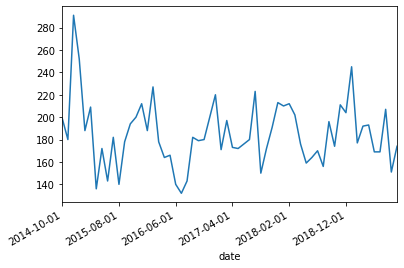

In [42]:
Plot_trends_all_surgeries(data)
Plot_trends_combined_surgeries(data)
Plot_trends_pick_surgeries(data, 'P84071')
Plot_trends_two_surgeries_by_IDs(data, 'P84071', 'P84049')

In [40]:
data['org_name'].str.endswith('THE ALEXANDRA PRACTICE').any()

True

In [41]:
##Known bugs - the org_name is case sensitive.
##

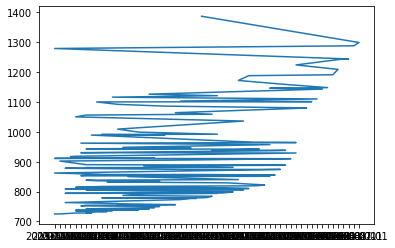

In [60]:
plt.plot(Outliers.date,Outliers.numerator)


In [54]:
HighOut

724.5

In [70]:
unique_outlier_dates = Outliers['date'].unique() ##Get a list outliers at unique dates


In [86]:
def Plot_outliers(data): 
    "test" # docstring to appear when help(?) is called
    unique_outlier_dates = Outliers['org_id'].unique() ##Get a list of dates with outliers

    ax = plt.gca() ##Set the default axis for the graph

    for date in unique_outlier_dates: ##For each date with outliers
        new_dataframe = Outliers[Outliers['org_id'] == str(date)] ##Get a new dataframe subset just for the one surgery 
        graph_points = new_dataframe[['date','numerator']] ##From the new dataframe, get the date and prescription number
    
        graph_points.plot(x='date',y='numerator', ax = ax) ##Plot date and prescriptions on same axis for all surgeries

    ax.get_legend().remove() ##Remove legend from graph, as very messy.
    plt.gcf().autofmt_xdate() ##Format the x-axis for date data
    plt.show() ##Show the plot


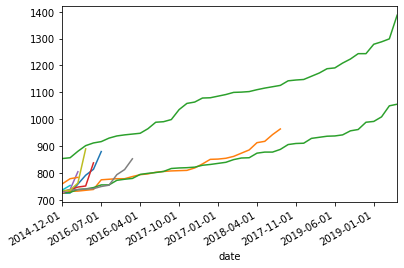

In [72]:
Plot_outliers(data)

In [87]:
?Plot_outliers

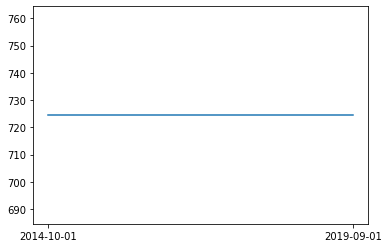

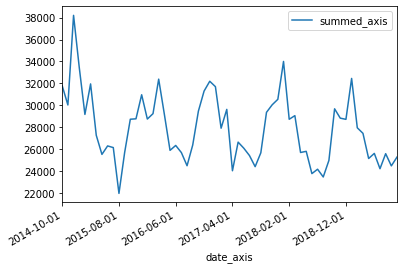

In [115]:
x1 = min(data.date) #set x coordinate for earliest date
x2 = max(data.date) # set x coordinate for latest date
y = HighOut # set y as the upper bound for outliers
l1 = [(x1,y),(x2,y)] #define function for line for upper bound
x = [min(data.date),max(data.date)]
y = [HighOut,HighOut]
PlotOut = plt.plot(x,y)
Plot_trends_combined_surgeries(data)

In [127]:

fig= plt.figure()
plt.plot(x,y)
plt.plot(new_dataframe[['date','numerator']])


IndentationError: unexpected indent (<ipython-input-127-06e3975c7b0c>, line 3)